In [2]:
import pandas as pd
import numpy as np
import yaml
import os
from pathlib import Path


def load_file(path):
  with open(path, "r") as f:
    return yaml.load(f, Loader=yaml.FullLoader)

dir_files = os.path.join(os.path.dirname(os.path.abspath("__file__")), "minizinc")
files = os.listdir(dir_files)
sols = [load_file(Path(dir_files,  f)) for f in files if f.endswith("_sol.yml")]

minizinc = []
for i in range(len(sols)):
  for j in range(len(sols[i])):
    if 'solution' in sols[i][j]:
      minizinc.append({
        'travellingPlan': sols[i][j]['solution']['order'],
        'pickupPlan': np.where(np.array(sols[i][j]['solution']['chosen']))[0].tolist(),
        'model': sols[i][j]['model'],
        'data_file': sols[i][j]['data_file'],
        'time': sols[i][j]['time'],
        'orgin_objective': sols[i][j]['solution']['objective'],
        'profit': sols[i][j]['solution']['profit'],
        'rental': sols[i][j]['solution']['rental'],
        'total_travel_time': sols[i][j]['solution'].get('total_travel_time', sols[i][j]['solution']['rental']),
      })
minizinc = pd.DataFrame(minizinc)
minizinc['data_file'] = minizinc['data_file'].apply(lambda x: x.split('/')[-1])
minizinc['model'] = minizinc['model'].apply(lambda x: x.split('/')[-1])
minizinc['is_blackbox'] = minizinc['model'].apply(lambda x: 'bb_' in x)
minizinc

,travellingPlan,pickupPlan,model,data_file,time,orgin_objective,profit,rental,total_travel_time,is_blackbox
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[26, 54, 55]",bb_ttp.mzn,n20_k3_c10000_l100_u200_r81.dzn,0.139,9281.334032,14119,4837.665968,4837.665968,True
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[26, 43, 53, 54, 56]",bb_ttp.mzn,n20_k3_c10000_l100_u200_r81.dzn,0.143,14903.631628,19833,4929.368372,4929.368372,True
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[9, 43, 53, 54, 56]",bb_ttp.mzn,n20_k3_c10000_l100_u200_r81.dzn,0.146,18832.151212,23839,5006.848788,5006.848788,True
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[9, 26, 37, 43, 54, 56]",bb_ttp.mzn,n20_k3_c10000_l100_u200_r81.dzn,0.147,25604.723547,30709,5104.276453,5104.276453,True
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[9, 16, 26, 43, 54, 56]",bb_ttp.mzn,n20_k3_c10000_l100_u200_r81.dzn,0.147,26194.009463,31457,5262.990537,5262.990537,True
...,...,...,...,...,...,...,...,...,...,...
302,"[1, 2, 4, 8, 10, 6, 5, 7, 3, 9]","[5, 13]",ttp.mzn,n10_k3_c5000_l10000_u10100_r46.dzn,5.194,14532.831195,14545,0.264539,12.168805,False
303,"[1, 2, 4, 8, 10, 9, 3, 7, 5, 6]","[5, 13]",ttp.mzn,n10_k3_c5000_l10000_u10100_r46.dzn,5.214,14534.239810,14545,0.233917,10.760190,False
304,"[1, 2, 6, 5, 7, 3, 9, 4, 8, 10]","[5, 13]",ttp.mzn,n10_k3_c5000_l10000_u10100_r46.dzn,9.032,14534.246765,14545,0.233766,10.753235,False
305,"[1, 2, 6, 5, 7, 3, 9, 4, 10, 8]","[5, 13]",ttp.mzn,n10_k3_c5000_l10000_u10100_r46.dzn,9.035,14534.333745,14545,0.231875,10.666255,False


In [29]:
tmp = times[['data_file', 'bb_time']].sort_values(['data_file', 'bb_time'])
for file in tmp['data_file'].unique():
    tmp.loc[tmp['data_file'] == file, 'diff'] = tmp[tmp['data_file'] == file]['bb_time'].diff()
tmp['diff'] = tmp['diff'].fillna(0)
tmp.to_csv('times_tmp.csv', index=False)

In [3]:
import csv
import ast
from pathlib import Path
import pandas as pd
import os
import numpy as np

# Read the input text file
root_dir_results = os.path.join(os.path.dirname(os.path.abspath("__file__")), "localsearch")

def read_file_in_chunks(file_path, chunk_size):
    """
    Reads a file in chunks of lines.
    
    :param file_path: Path to the file to be read.
    :param chunk_size: Number of lines to read at a time.
    :return: Yields chunks of lines.
    """
    with open(file_path, "r") as file:
        chunk = []
        for line in file:
            stripped_line = line.strip()  # Remove any leading/trailing whitespace
            if stripped_line:  # Only add non-empty lines
                chunk.append(stripped_line)
                if len(chunk) == chunk_size:
                    yield chunk  # Return the chunk when it reaches the desired size
                    chunk = []  # Reset the chunk for the next group of lines
        if chunk:
            yield chunk  # Yield the remaining lines if any

def convert_to_csv(input_file_path: str):
    df = {
        'data_file': [],
        'algorithm': [],
        'final_capacity_free': [],
        'final_weight': [],
        'final_profit': [],
        'final_distance': [],
        'final_travel_time': [],
        'objective_score': [],
        'computation_time': [],
        'statistics': [],
        'tsp_tour': [],
        'packing_plan': []
    }

    current_data_file = None
    algorithm = Path(input_file_path).name.split("_")[0]
    for lines in read_file_in_chunks(input_file_path, 3):
        if lines[0].startswith("minizinc_n"):
            data_file, statistics = lines[0].split(": ")
            current_data_file = data_file
            statistics = statistics
            if not (lines[1].startswith("tspTour") and lines[2].startswith("packingPlan")):
                tsp_tour = (np.array(ast.literal_eval(lines[1])) - 1).tolist()
                packing_plan = (np.array(ast.literal_eval(lines[2])) - 1).tolist()
            else:
                tsp_tour = (np.array(ast.literal_eval(lines[1].split(" ", 1)[1]))[:-1]).tolist()
                packing_plan = (np.where(np.array(ast.literal_eval(lines[2].split(" ", 1)[1])) == 1)[0]).tolist()
        elif lines[1].startswith("tspTour") and lines[2].startswith("packingPlan"):
            statistics = lines[0]
            tsp_tour = (np.array(ast.literal_eval(lines[1].split(" ", 1)[1]))[:-1]).tolist()
            packing_plan = (np.where(np.array(ast.literal_eval(lines[2].split(" ", 1)[1])) == 1)[0]).tolist()
        else:
            statistics = lines[0]
            tsp_tour = (np.array(ast.literal_eval(lines[1])) -1).tolist()
            packing_plan = lines[2].replace(",]", "]")
            packing_plan = (np.array(ast.literal_eval(packing_plan)) - 1).tolist()
        final_capacity_free, final_weight, final_profit, final_distance, final_travel_time, objective_score, computation_time = statistics.split()
        df['data_file'].append(current_data_file)
        df['final_capacity_free'].append(final_capacity_free)
        df['final_weight'].append(final_weight)
        df['final_profit'].append(final_profit)
        df['final_distance'].append(final_distance)
        df['final_travel_time'].append(final_travel_time)
        df['objective_score'].append(objective_score)
        df['computation_time'].append(computation_time)
        df['algorithm'].append(algorithm)
        df['statistics'].append(statistics)
        df['tsp_tour'].append(tsp_tour)
        df['packing_plan'].append(packing_plan)
    df['pickupPlan'] = df['packing_plan']
    df['travellingPlan'] = df['tsp_tour']
    df = pd.DataFrame(df)    
    df['algorithm'] = algorithm
    return df

files = [os.path.join(root_dir_results, f) for f in os.listdir(root_dir_results) if f.endswith("_output.txt")]
localsearch = []
for f in files:
    try:
        df = convert_to_csv(f)
        localsearch.append(df)
    except Exception as e:
        import traceback
        print(f"Error processing {f}: {e}")
        traceback.print_exception(type(e), e, e.__traceback__)
localsearch = pd.concat(localsearch)
localsearch['time'] = localsearch['computation_time'].astype(int) / 1000
localsearch

,data_file,algorithm,final_capacity_free,final_weight,final_profit,final_distance,final_travel_time,objective_score,computation_time,statistics,tsp_tour,packing_plan,pickupPlan,travellingPlan,time
0,minizinc_n10_k3_c5000_l10000_u10100_r46.ttp,22,419.0,4581.0,12538.0,2274,0.2261953712491902,12527.595012922537,210,419.0 4581.0 12538.0 2274 0.2261953712491902 1...,"[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]","[1, 19]","[1, 19]","[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]",0.210
1,minizinc_n10_k3_c5000_l10000_u10100_r46.ttp,22,2417.0,2583.0,14545.0,2274,0.2258526959211455,14534.610775987627,225,2417.0 2583.0 14545.0 2274 0.2258526959211455 ...,"[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]","[13, 19]","[13, 19]","[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]",0.225
2,minizinc_n10_k3_c5000_l10000_u10100_r46.ttp,22,2417.0,2583.0,14545.0,2274,0.2258526959211455,14534.610775987627,599790,2417.0 2583.0 14545.0 2274 0.2258526959211455 ...,"[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]","[13, 19]","[13, 19]","[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]",599.790
3,minizinc_n10_k15_c5000_l10000_u11000_r49.ttp,22,-17418.0,22418.0,15839.0,2730,0.2874609180086634,15824.914415017576,599790,-17418.0 22418.0 15839.0 2730 0.28746091800866...,"[0, 4, 6, 1, 3, 9, 5, 2, 7, 8]","[123, 125, 127]","[123, 125, 127]","[0, 4, 6, 1, 3, 9, 5, 2, 7, 8]",599.790
4,minizinc_n20_k3_c10000_l100_u200_r81.ttp,22,409.0,9591.0,5519.0,3932,20.779518205399174,3835.859025362667,22,409.0 9591.0 5519.0 3932 20.779518205399174 38...,"[0, 7, 4, 16, 11, 14, 1, 15, 12, 18, 10, 3, 9,...",[12],[12],"[0, 7, 4, 16, 11, 14, 1, 15, 12, 18, 10, 3, 9,...",0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,minizinc_n10_k3_c5000_l10000_u10100_r46.ttp,21,642.0,4358.0,12223.0,2274,0.22545133714272808,12212.629238491434,81,642.0 4358.0 12223.0 2274 0.22545133714272808 ...,"[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]","[1, 25]","[1, 25]","[0, 5, 4, 6, 2, 8, 3, 9, 7, 1]",0.081
1,minizinc_n10_k15_c5000_l10000_u11000_r49.ttp,21,99.0,4901.0,18991.0,2730,0.2507608752851173,18978.71271711103,93,99.0 4901.0 18991.0 2730 0.2507608752851173 18...,"[0, 4, 6, 1, 3, 9, 5, 2, 7, 8]","[123, 125, 127]","[123, 125, 127]","[0, 4, 6, 1, 3, 9, 5, 2, 7, 8]",0.093
2,minizinc_n20_k3_c10000_l100_u200_r81.ttp,21,409.0,9591.0,5519.0,3932,20.779518205399174,3835.859025362667,94,409.0 9591.0 5519.0 3932 20.779518205399174 38...,"[0, 7, 4, 16, 11, 14, 1, 15, 12, 18, 10, 3, 9,...",[54],[54],"[0, 7, 4, 16, 11, 14, 1, 15, 12, 18, 10, 3, 9,...",0.094
3,minizinc_n20_k15_c5000_l100_u200_r32.ttp,21,54.0,4946.0,31954.0,4141,22.05480245502266,31248.246321439274,103,54.0 4946.0 31954.0 4141 22.05480245502266 312...,"[0, 14, 11, 4, 8, 10, 17, 6, 7, 15, 3, 1, 12, ...","[134, 270, 272, 274, 277]","[134, 270, 272, 274, 277]","[0, 14, 11, 4, 8, 10, 17, 6, 7, 15, 3, 1, 12, ...",0.103


In [4]:
mzn = minizinc[['orgin_objective', 'data_file', 'model', 'time', 'profit', 'total_travel_time', 'is_blackbox']].copy()
mzn['algorithm'] = mzn['is_blackbox'].apply(lambda x: 'mzn' + ('_blackbox' if x else ''))
mzn['data_file'] = mzn['data_file'].apply(lambda x: x.rstrip('.dzn')) 
mzn = mzn.rename(columns={'orgin_objective': 'objective', 'total_travel_time': 'rental'})
mzn = mzn.drop(columns=['is_blackbox', 'model'])
mzn

,objective,data_file,time,profit,rental,algorithm
0,9281.334032,n20_k3_c10000_l100_u200_r81,0.139,14119,4837.665968,mzn_blackbox
1,14903.631628,n20_k3_c10000_l100_u200_r81,0.143,19833,4929.368372,mzn_blackbox
2,18832.151212,n20_k3_c10000_l100_u200_r81,0.146,23839,5006.848788,mzn_blackbox
3,25604.723547,n20_k3_c10000_l100_u200_r81,0.147,30709,5104.276453,mzn_blackbox
4,26194.009463,n20_k3_c10000_l100_u200_r81,0.147,31457,5262.990537,mzn_blackbox
...,...,...,...,...,...,...
302,14532.831195,n10_k3_c5000_l10000_u10100_r46,5.194,14545,12.168805,mzn
303,14534.239810,n10_k3_c5000_l10000_u10100_r46,5.214,14545,10.760190,mzn
304,14534.246765,n10_k3_c5000_l10000_u10100_r46,9.032,14545,10.753235,mzn
305,14534.333745,n10_k3_c5000_l10000_u10100_r46,9.035,14545,10.666255,mzn


In [6]:
alogrithms = localsearch[['objective_score', 'data_file', 'algorithm', 'final_profit', 'final_travel_time', 'time']]
alogrithms = alogrithms.rename(columns={'objective_score': 'objective', 'final_profit': 'profit', 'final_travel_time': 'rental'})

for col in ['objective', 'profit', 'rental']:
    alogrithms[col] = alogrithms[col].astype(float)

alogrithms.loc[alogrithms['data_file'] == 'minizinc_n10_k3_c5000_l10000_u10100_r46.ttp', 'rental'] *= 46
alogrithms.loc[alogrithms['data_file'] == 'minizinc_n10_k15_c5000_l10000_u11000_r49.ttp', 'rental'] *= 49
alogrithms.loc[alogrithms['data_file'] == 'minizinc_n20_k3_c10000_l100_u200_r81.ttp', 'rental'] *= 81
alogrithms.loc[alogrithms['data_file'] == 'minizinc_n20_k15_c5000_l100_u200_r32.ttp', 'rental'] *= 32
alogrithms.loc[alogrithms['data_file'] == 'minizinc_n20_k20_c1000_l1000_u2000_r46.ttp', 'rental'] *= 46

alogrithms['data_file'] = alogrithms['data_file'].apply(lambda x: x.rstrip('.ttp').split('_', 1)[1])
alogrithms

,objective,data_file,algorithm,profit,rental,time
0,12527.595013,n10_k3_c5000_l10000_u10100_r46,22,12538.0,10.404987,0.210
1,14534.610776,n10_k3_c5000_l10000_u10100_r46,22,14545.0,10.389224,0.225
2,14534.610776,n10_k3_c5000_l10000_u10100_r46,22,14545.0,10.389224,599.790
3,15824.914415,n10_k15_c5000_l10000_u11000_r49,22,15839.0,14.085585,599.790
4,3835.859025,n20_k3_c10000_l100_u200_r81,22,5519.0,1683.140975,0.022
...,...,...,...,...,...,...
0,12212.629238,n10_k3_c5000_l10000_u10100_r46,21,12223.0,10.370762,0.081
1,18978.712717,n10_k15_c5000_l10000_u11000_r49,21,18991.0,12.287283,0.093
2,3835.859025,n20_k3_c10000_l100_u200_r81,21,5519.0,1683.140975,0.094
3,31248.246321,n20_k15_c5000_l100_u200_r32,21,31954.0,705.753679,0.103


In [18]:

# Define a color map for the algorithms
colors = {
    'mzn': 'blue',
    'mzn_blackbox': 'green',
    '21': 'grey',
    '22': 'purple',
    '23': 'orange',
    '24': 'yellow',
    '29': 'black',
    '30': 'plum',
}

results = pd.concat([mzn, alogrithms])
results['objective'] = results['objective'].astype(float).round(2)
results.to_csv('results.csv', index=False)
results 

,objective,data_file,time,profit,rental,algorithm
0,9281.33,n20_k3_c10000_l100_u200_r81,0.139,14119.0,4837.665968,mzn_blackbox
1,14903.63,n20_k3_c10000_l100_u200_r81,0.143,19833.0,4929.368372,mzn_blackbox
2,18832.15,n20_k3_c10000_l100_u200_r81,0.146,23839.0,5006.848788,mzn_blackbox
3,25604.72,n20_k3_c10000_l100_u200_r81,0.147,30709.0,5104.276453,mzn_blackbox
4,26194.01,n20_k3_c10000_l100_u200_r81,0.147,31457.0,5262.990537,mzn_blackbox
...,...,...,...,...,...,...
0,12212.63,n10_k3_c5000_l10000_u10100_r46,0.081,12223.0,10.370762,21
1,18978.71,n10_k15_c5000_l10000_u11000_r49,0.093,18991.0,12.287283,21
2,3835.86,n20_k3_c10000_l100_u200_r81,0.094,5519.0,1683.140975,21
3,31248.25,n20_k15_c5000_l100_u200_r32,0.103,31954.0,705.753679,21


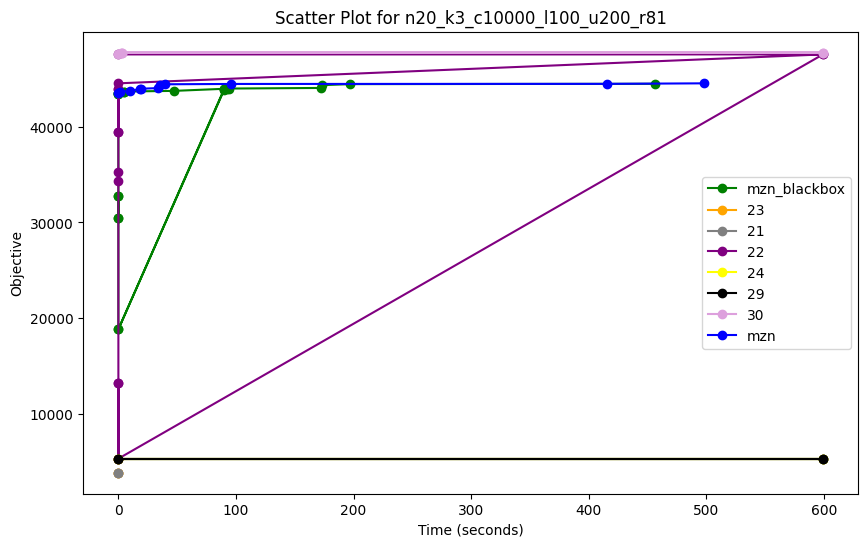

In [13]:
import matplotlib.pyplot as plt

data_file = 'n20_k3_c10000_l100_u200_r81'
filtered_data = results[results['data_file'] == data_file].copy()
max_obj = filtered_data['objective'].max()

# Create scatter plot for filtered_data
plt.figure(figsize=(10, 6))
dis = filtered_data.copy()
dis['time'] = (dis['time'] // 1).astype(int)
dis = dis.loc[dis.groupby(['algorithm', 'time'])['objective'].idxmax()]
for algo in dis['algorithm'].unique():
    subset = dis[dis['algorithm'] == algo]
    plt.plot(subset['time'], subset['objective'], marker='o', label=algo, color=colors.get(algo, 'blue'))
plt.title(f'Scatter Plot for {data_file}')
plt.xlabel('Time (seconds)')
plt.ylabel('Objective')
plt.legend()
plt.show()

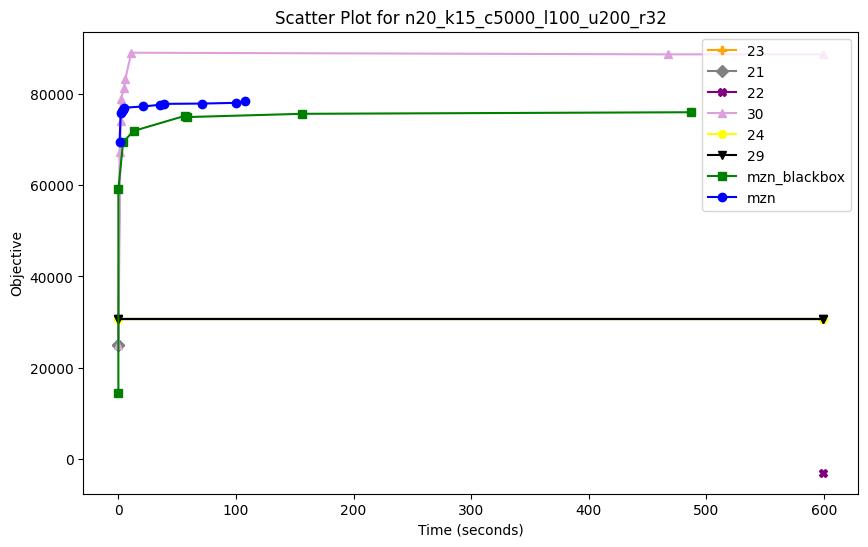

In [14]:
import matplotlib.pyplot as plt

data_file = 'n20_k15_c5000_l100_u200_r32'

filtered_data = results[results['data_file'] == data_file].copy()
filtered_data['objective'] = filtered_data['profit'] - filtered_data['rental'] * 10

# Create scatter plot for filtered_data
plt.figure(figsize=(10, 6))
dis = filtered_data.copy()
def plot_filtered_data(filtered_data, data_file):
    # Define a color map for the algorithms
    colors = {
        'mzn': 'blue',
        'mzn_blackbox': 'green',
        '21': 'grey',
        '22': 'purple',
        '23': 'orange',
        '24': 'yellow',
        '29': 'black',
        '30': 'plum',
    }
    markers = {
        'mzn': 'o',
        'mzn_blackbox': 's',
        '21': 'D',
        '22': 'X',
        '23': 'P',
        '24': 'H',
        '29': 'v',
        '30': '^',
    }
    filtered_data['time'] = (filtered_data['time'] // 1).astype(int)
    filtered_data = filtered_data.loc[filtered_data.groupby(['algorithm', 'time'])['objective'].idxmax()]
    for algo in filtered_data['algorithm'].unique():
        subset = filtered_data[filtered_data['algorithm'] == algo]
        plt.plot(subset['time'], subset['objective'], marker=markers.get(algo, 'o'), label=algo, color=colors.get(algo))
    plt.title(f'Scatter Plot for {data_file}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective')
    plt.legend()
    plt.show()

plot_filtered_data(dis, data_file)

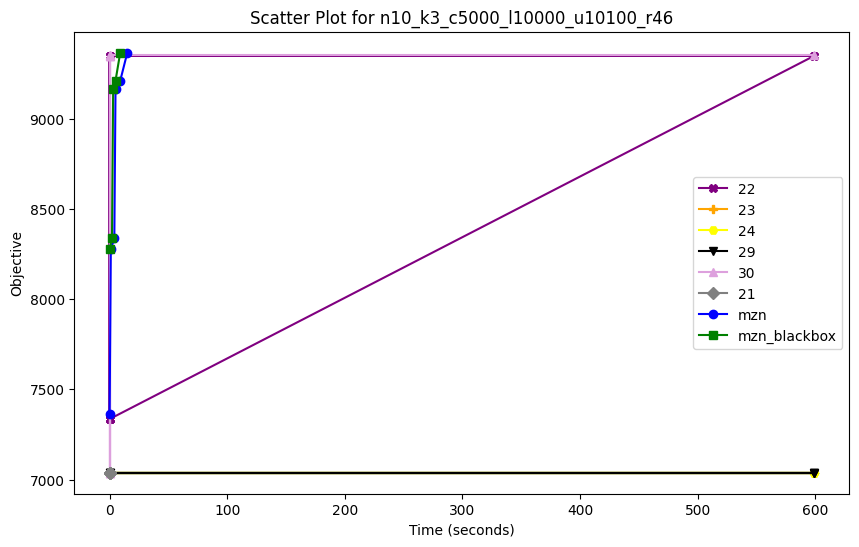

In [15]:
import matplotlib.pyplot as plt

data_file = 'n10_k3_c5000_l10000_u10100_r46'

filtered_data = results[results['data_file'] == data_file].copy()
filtered_data['objective'] = filtered_data['profit'] - filtered_data['rental'] * 500

# Create scatter plot for filtered_data
plt.figure(figsize=(10, 6))
dis = filtered_data.copy()

plot_filtered_data(dis, data_file)

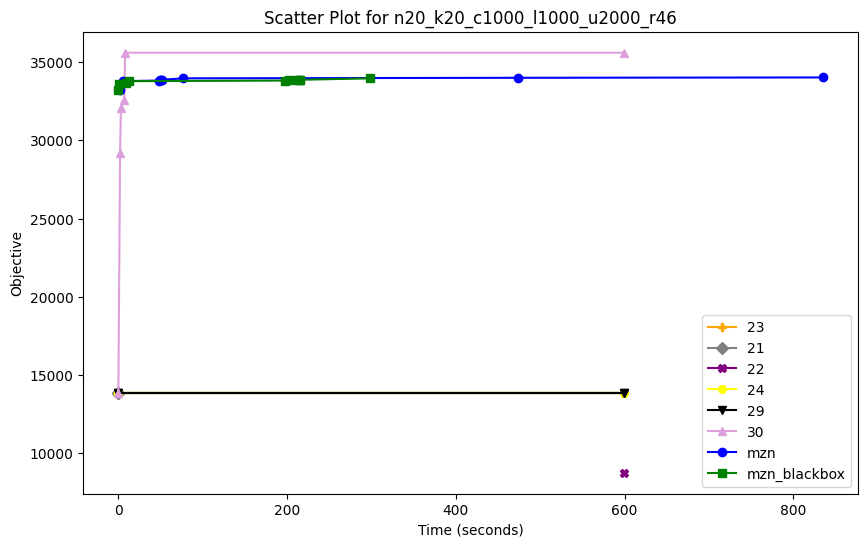

In [16]:
import matplotlib.pyplot as plt

data_file = 'n20_k20_c1000_l1000_u2000_r46'

filtered_data = results[results['data_file'] == data_file].copy()
filtered_data['objective'] = filtered_data['profit'] - filtered_data['rental'] * 10

# Create scatter plot for filtered_data
plt.figure(figsize=(10, 6))
dis = filtered_data.copy()
plot_filtered_data(dis, data_file)

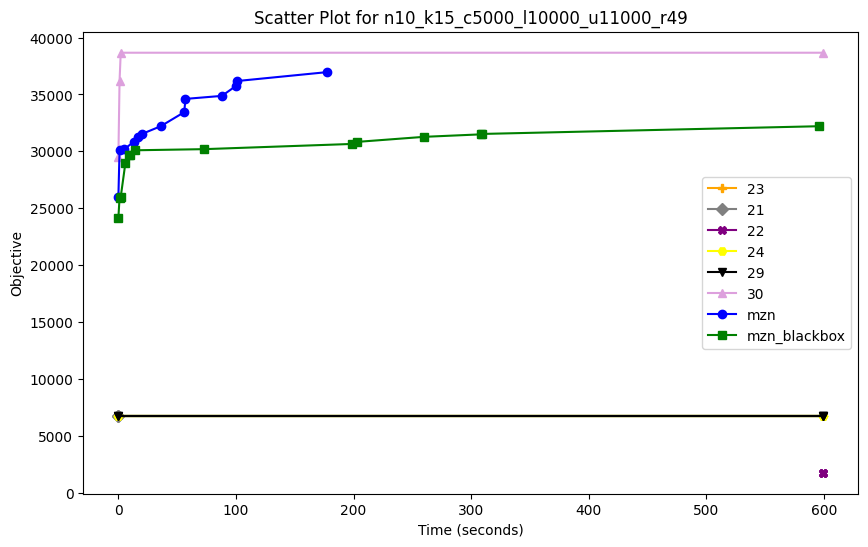

In [17]:
import matplotlib.pyplot as plt

data_file = 'n10_k15_c5000_l10000_u11000_r49'

filtered_data = results[results['data_file'] == data_file].copy()
filtered_data['objective'] = filtered_data['profit'] - filtered_data['rental'] * 1000

# Create scatter plot for filtered_data
plt.figure(figsize=(10, 6))
dis = filtered_data.copy()
dis['time'] = (dis['time'] // 1).astype(int)
plot_filtered_data(dis, data_file)